<center><h1>Evaluate LLMs Using FLASK Benchmarks</h1></center>

In [1]:
!pip install matplotlib

In [1]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="ENTER_LOCATION_OF_KEY_JSON_FILE" # place the key JSON file in the same folder as your notebook
os.environ["OPENAI_API_KEY"] = "ENTER_YOUR_OPENWEATHERMAP_API_KEY" # Replace with your OpenAI API key

In [2]:
PROJECT_ID = "ENTER_PROJECT_ID" # use your project id
REGION = "ENTER_REGION"  # enter region
BUCKET_URI = f"ENTER_BUCKET_URI" # create your own bucket

In [3]:
import vertexai
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

In [4]:
from langchain.llms import VertexAI
llm_gemini_pro = VertexAI(model_name="gemini-pro")
llm_text_bison =  VertexAI(model_name="text-bison@001")


C:\Users\Srishti Chouhan\anaconda3\envs\genai_llm\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.vertexai.VertexAI` was deprecated in langchain-community 0.0.12 and will be removed in 0.2.0. An updated version of the class exists in the langchain-google-vertexai package and should be used instead. To use it run `pip install -U langchain-google-vertexai` and import as `from langchain_google_vertexai import VertexAI`.
  warn_deprecated(


In [5]:
# @title # Choose prompts for evaluation
prompt_1 = "Provide me with the current temperature and humidity levels." # @param {type:"string"}
prompt_2 = "What is the current wind speed and direction?" # @param {type:"string"}
prompt_3 = "Give me an update on the current atmospheric pressure." # @param {type:"string"}
prompt_4 = "What is the current visibility in the area?" # @param {type:"string"}
prompt_5 = "Tell me about any ongoing precipitation, such as rain or snow." # @param {type:"string"}
prompt_6 = "Provide information on the cloud cover at the moment." # @param {type:"string"}
prompt_7 = "What is the current temperature for this location?" # @param {type:"string"}
prompt_8 = "Provide a summary of the weather forecast for the next 24 hours." # @param {type:"string"}
prompt_9 = "Give me details on any weather warnings or advisories in effect right now." # @param {type:"string"}
prompt_10 = "Describe the current weather conditions, including any notable features like fog or frost." # @param {type:"string"}

prompts = [
    prompt_1,
    prompt_2,
    prompt_3,
    prompt_4,
    prompt_5,
    prompt_6,
    prompt_7,
    prompt_8,
    prompt_9,
    prompt_10
    ]

In [6]:
# @title Generate a response per model
from ast import literal_eval

system_prompt = "Provide a comprehensive and detailed response that includes innovative insights and clear, structured explanations. Focus on delivering practical, actionable advice. Ensure relevance to the startup and tech industry, emphasizing current trends and future possibilities. Be specific in your examples and explanations, and consider adding unique perspectives or novel approaches to standard practices. Aim for clarity in communication, organizing your response logically and coherently.\n"

responses = []
for prompt in prompts:
    gemini_response = llm_gemini_pro(system_prompt + prompt)
    text_bison_response = llm_text_bison(system_prompt + prompt)
    #oai_advice = guidance_helper(system_prompt, models.VertexAI("chat-bison"), prompt, "advice")
    responses.append((gemini_response, text_bison_response))

C:\Users\Srishti Chouhan\anaconda3\envs\genai_llm\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


**Digression**: What if the model that is being evaluated doesn't offer llm() function?!

In this case, use the guidance library

In [8]:
!pip install -q guidance

In [9]:
import guidance
from guidance import models, gen, system, user, assistant
# @title Helper functions
def guidance_helper(system_prompt, model, prompt, output_key, max_tokens=1500):
    mdl = model
    with system():
        mdl += system_prompt
    with user():
        mdl += prompt
    with assistant():
        mdl += gen(name=output_key, max_tokens=max_tokens)
    return mdl[output_key]

**End of Digression**

In [12]:
# @title Score each model response

system_prompt = """You are to evaluate each response on the likert scale (1-5) for dimensions including:
Robustness
Correctness
Efficiency
Factuality
Commonsense
Comprehension
Insightfulness
Completeness
Metacognition
Readability
Conciseness
Harmlessness

Make sure to structure your responses as JSON.
"""
scores = []
for response in responses:
    score = guidance_helper(system_prompt, models.OpenAI("gpt-4"), "Model A:\n" + "\n\nModel B:\n".join(response), "scores", 2000)
    scores.append(score)

In [13]:
for score in scores:
    print(score)

#for response in responses:
#    print (response)

{
"Model A": {
"Robustness": 5,
"Correctness": 5,
"Efficiency": 4,
"Factuality": 5,
"Commonsense": 5,
"Comprehension": 5,
"Insightfulness": 3,
"Completeness": 4,
"Metacognition": 5,
"Readability": 5,
"Conciseness": 5,
"Harmlessness": 5
},

"Model B": {
"Robustness": 2,
"Correctness": 1,
"Efficiency": 5,
"Factuality": 1,
"Commonsense": 2,
"Comprehension": 5,
"Insightfulness": 2,
"Completeness": 5,
"Metacognition": 1,
"Readability": 5,
"Conciseness": 5,
"Harmlessness": 5
}
}
{
"Model A": {
"Robustness": 5,
"Correctness": 5,
"Efficiency": 4,
"Factuality": 5,
"Commonsense": 5,
"Comprehension": 5,
"Insightfulness": 5,
"Completeness": 4,
"Metacognition": 5,
"Readability": 5,
"Conciseness": 3,
"Harmlessness": 5
},
"Model B": {
"Robustness": 3,
"Correctness": 5,
"Efficiency": 5,
"Factuality": 3,
"Commonsense": 5,
"Comprehension": 5,
"Insightfulness": 2,
"Completeness": 3,
"Metacognition": 2,
"Readability": 5,
"Conciseness": 5,
"Harmlessness": 5
}
}
{
"Model A": {
"Robustness": 5,
"Correctness"

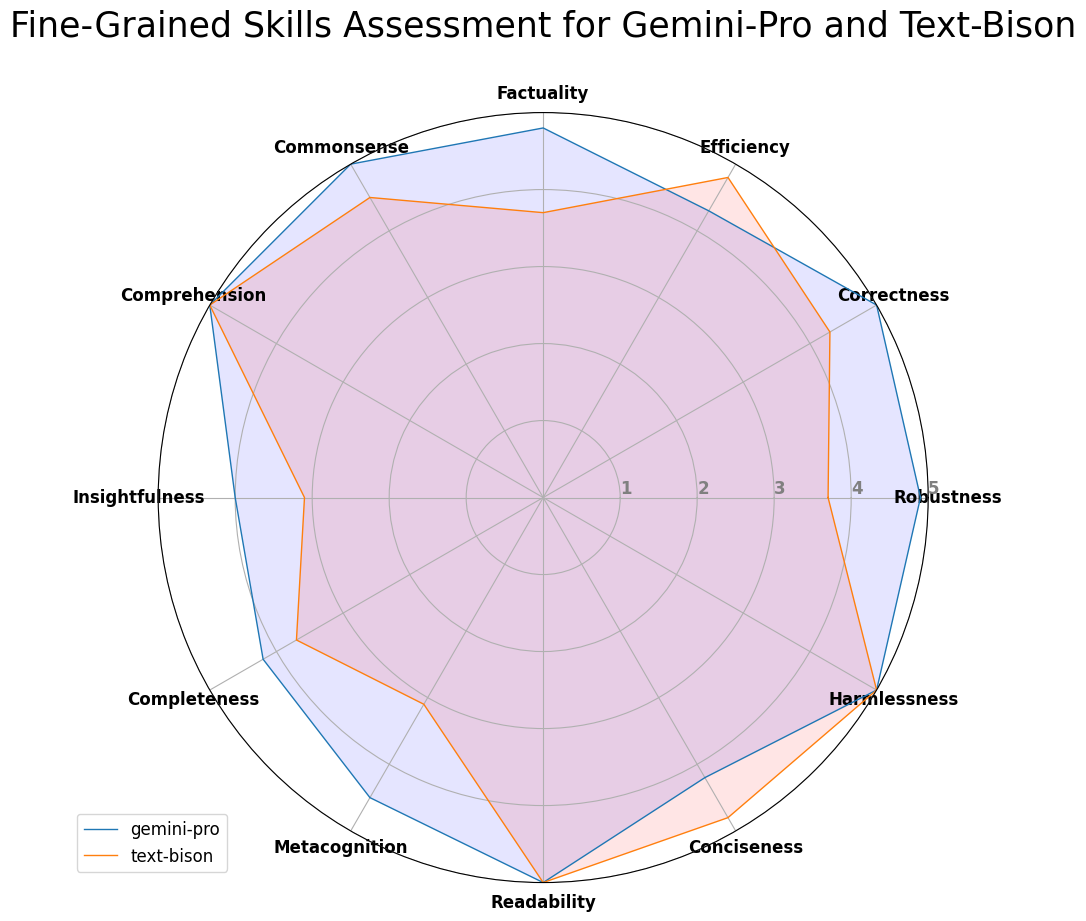

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from collections import defaultdict

# Data
avg_data = [literal_eval(score) for score in scores]
average_data = defaultdict(lambda: defaultdict(list))

# Accumulate the values for each model and attribute
for entry in avg_data:
    for model, attributes in entry.items():
        if isinstance(attributes, dict):
            for attribute, value in attributes.items():
                average_data[model][attribute].append(value)


# Calculate the averages
for model, attributes in average_data.items():
    for attribute, values in attributes.items():
        average_data[model][attribute] = sum(values) / len(values)

# Convert defaultdict to regular dict for display
average_data_dict = {model: dict(attributes) for model, attributes in average_data.items()}
average_data_dict = {key: average_data_dict[key] for key in ['Model A', 'Model B']}

# Convert to DataFrame
df = pd.DataFrame(average_data_dict)

# Number of variables
categories = list(df.index)
N = len(categories)

# What will be the angle of each axis in the plot?
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, fontsize=12, fontweight='bold')

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([1,2,3,4,5], ["1","2","3","4","5"], color="grey", size=7, fontsize=12, fontweight='bold')
plt.ylim(0,5)

# Model A
values = list(df['Model A']) + list(df['Model A'])[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='gemini-pro')
ax.fill(angles, values, 'b', alpha=0.1)

# Model B
values = list(df['Model B']) + list(df['Model B'])[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='text-bison')
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)

plt.title('Fine-Grained Skills Assessment for Gemini-Pro and Text-Bison\n', fontsize=25)

# Show the plot
plt.show()

In [18]:
plt.savefig('flask_eval.png')

<Figure size 640x480 with 0 Axes>